<a href="https://colab.research.google.com/github/Aliya032/OCR/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

In [8]:
!pip install opendatasets

In [9]:
import opendatasets as od
import pandas

In [18]:
od.download('https://www.kaggle.com/datasets/harieh/ocr-dataset/')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aliyafatima032
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/harieh/ocr-dataset


100%|██████████| 153M/153M [00:00<00:00, 165MB/s]


In [10]:
def directory_to_df(path: '/content/ocr-dataset/dataset'):
  df = []
  chars = 'abcdefghijklmnopqrstuvwxyz' # to include lowercase letters only
  for cls in os.listdir(path):
    cls_path = os.path.join(path, cls)
    cls_name = cls.split('_')[0]
    if not cls_name in chars:
      continue
    for img_path in os.listdir(cls_path):
      direct = os.path.join(cls_path, img_path)
      df.append([direct, cls_name])

  df = pd.DataFrame(df, columns=['image', 'label'])
  print('The number of samples found: ', len(df))
  return df.copy()


In [12]:
def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:

    path: String -> a directory of the image
    _____________________________________________________________
    Return:

    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image



In [14]:

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:

    img: numpy.array of N-D

    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:

    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()


In [15]:
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [16]:
# pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate = 0.00001, epsilon=1e-16)
loss = 'categorical_crossentropy'
EPOCHS = 10

## 3. Reading & preparing the dataset

In [19]:
# Reading the dataset in dataframe
main_path = '/content/ocr-dataset/dataset'
df = directory_to_df(main_path) #convert the dataset into df of two columns
df.head()


The number of samples found:  85199


,image,label
0,/content/ocr-dataset/dataset/h_L/H_L_830.png,h
1,/content/ocr-dataset/dataset/h_L/H_L_1884.png,h
2,/content/ocr-dataset/dataset/h_L/H_L_979.png,h
3,/content/ocr-dataset/dataset/h_L/H_L_1942.png,h
4,/content/ocr-dataset/dataset/h_L/H_L_2603.png,h


In [20]:
df['label'].value_counts()

,count
label,
e,3284
r,3284
m,3281
n,3281
a,3281
q,3279
u,3278
i,3277
d,3277


### 3.1 Splitting the dataframe

- The dataframe is splitted to get 70% of the dataset for `training` & 30% for `testing`.
- The training set is splitted into `training` & `vaidation` to enhance model tranining.

In [21]:
# splitting for training & testing (70, 30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 41)
training_df = pd.concat((X_train, y_train), axis=1)
testing_df = pd.concat((X_test, y_test), axis=1)

In [22]:
training_df.head()

,image,label
64309,/content/ocr-dataset/dataset/f_L/F_L_2807.png,f
4822,/content/ocr-dataset/dataset/v_L/V_L_263.png,v
41804,/content/ocr-dataset/dataset/r_L/R_L_1081.png,r
67645,/content/ocr-dataset/dataset/s_L/S_L_1239.png,s
84614,/content/ocr-dataset/dataset/y_L/Y_L_2874.png,y


In [24]:
# Splitting for training & validation (75, 25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 41)
training_df = pd.concat((X_train, y_train), axis=1)
validation_df = pd.concat((X_valid, y_valid), axis=1)

#### 3.2 Creating Generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also it enhances the RAM usage.

In [25]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [26]:
# Making a mapping of the classes & the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

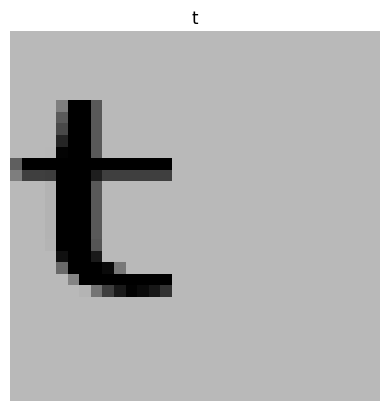

The shape of the image: (32, 32, 3)


In [27]:
# Reading a sample from the dataset.
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

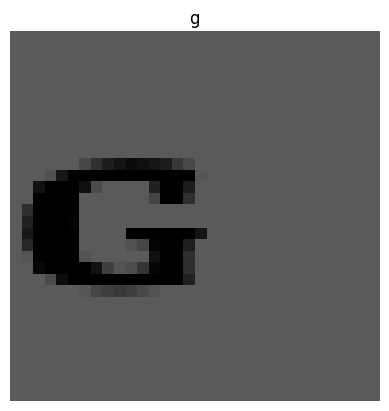

The shape of the image: (32, 32, 3)


In [28]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

###4. Modelling
Our target is to build a `custom CNN model` to train on our targeted images for the `OCR` application. In advance, I'll try to use 4 pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.

**The targeted pre-trained models are the following:**
- *EfficientNetB7*
- *MobileNetV2*
- *VGG19*
- *DenseNet121*

***The fine-tuning strategy:*** Using a small value of `LR` of the optimizer `Adam` will make an efficient use of pre-trained models on the dataset without **FREEZING** the input layers in which better performance is required in the case.

#### 4.1 Custom CNN

In [29]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [30]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 32, 32, 3)           84        
                                                                 
 conv2d_1 (Conv2D)           (32, 30, 30, 128)         3584      
                                                                 
 max_pooling2d (MaxPooling2  (32, 10, 10, 128)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 8, 8, 256)           295168    
                                                                 
 dropout (Dropout)           (32, 8, 8, 256)           0         
                                                                 
 conv2d_3 (Conv2D)           (32, 4, 4, 256)           590080    
                                                        

In [31]:
#Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [32]:
# different num of epochs will be given for better convergence for the custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20
1397/1398 [============================>.] - ETA: 0s - loss: 1.2546 - accuracy: 0.6424
Epoch 1: val_loss improved from inf to 0.42510, saving model to CustomCnn_model.keras
1398/1398 [==============================] - 71s 50ms/step - loss: 1.2540 - accuracy: 0.6426 - val_loss: 0.4251 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 2/20
1397/1398 [============================>.] - ETA: 0s - loss: 0.4467 - accuracy: 0.8765
Epoch 2: val_loss improved from 0.42510 to 0.35951, saving model to CustomCnn_model.keras
1398/1398 [==============================] - 69s 49ms/step - loss: 0.4467 - accuracy: 0.8765 - val_loss: 0.3595 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 3/20
1398/1398 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8984
Epoch 3: val_loss did not improve from 0.35951
1398/1398 [==============================] - 69s 49ms/step - loss: 0.3697 - accuracy: 0.8984 - val_loss: 0.3600 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 4/20
1398/1398 [=================

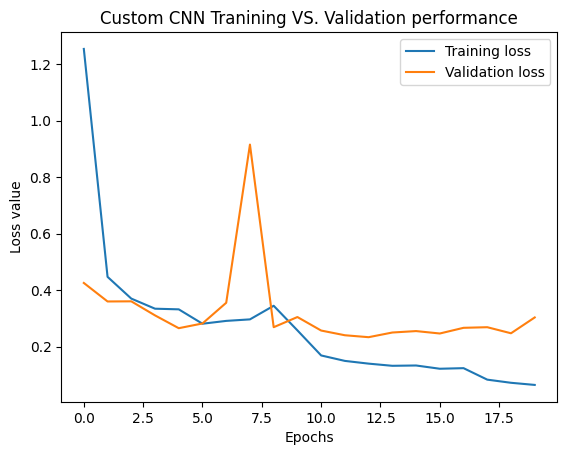

In [33]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Custom CNN Tranining VS. Validation performance')
plt.show()

In [34]:

# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

799/799 [==============================] - 12s 15ms/step


In [35]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.95      0.95      1004
           b       0.95      0.98      0.97       973
           c       0.93      0.96      0.95       974
           d       0.96      0.97      0.97       992
           e       0.95      0.94      0.95      1005
           f       0.97      0.95      0.96       996
           g       0.95      0.96      0.95       986
           h       0.98      0.95      0.96      1009
           i       0.97      0.96      0.96      1009
           j       0.96      0.97      0.97       979
           k       0.95      0.98      0.97       952
           l       0.94      0.94      0.94      1044
           m       1.00      0.95      0.97       981
           n       0.95      0.96      0.95       963
           o       0.94      0.97      0.95       930
           p       0.96      0.96      0.96       983
           q       0.98      0.95      0.

#### 4.2 EfficientNetB7

In [36]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

258076736/258076736 [==============================] - 1s 0us/step


In [37]:
EffNetB7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 1, 1, 2560)        64097687  
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2622464   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 26)                13338     
                                                      

In [38]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 2.6066 - accuracy: 0.2700
Epoch 1: val_loss improved from inf to 2.16540, saving model to EfficientNetB7_model.keras
1398/1398 [==============================] - 1171s 790ms/step - loss: 2.6066 - accuracy: 0.2700 - val_loss: 2.1654 - val_accuracy: 0.3742 - lr: 1.0000e-05
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 1.4174 - accuracy: 0.5965
Epoch 2: val_loss improved from 2.16540 to 1.06899, saving model to EfficientNetB7_model.keras
1398/1398 [==============================] - 1102s 788ms/step - loss: 1.4174 - accuracy: 0.5965 - val_loss: 1.0690 - val_accuracy: 0.7007 - lr: 1.0000e-05
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.7286
Epoch 3: val_loss improved from 1.06899 to 0.71567, saving model to EfficientNetB7_model.keras
1398/1398 [==============================] - 1101s 788ms/step - loss: 0.9569 - accuracy: 0.7286 - val_loss: 0.7157 

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('EfficientNetB7 Training vs Validation Performance')
plt.show()

In [ ]:
#Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))

In [ ]:
print('\t The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

#### 4.3 MobileNetV2

In [ ]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [ ]:
MobNetV2.summary()

In [ ]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

#### 4.4 VGG19

In [ ]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

In [ ]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

#### 4.5 DenseNet121

In [ ]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

In [ ]:
Den.summary()

In [ ]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

## 5. Evaluation & Comparison